# Préambule

## Imports

In [1]:
# setting up sys.path for relative imports
from pathlib import Path
import sys
project_root = str(Path(sys.path[0]).parents[1].absolute())
if project_root not in sys.path:
    sys.path.append(project_root)

In [73]:
# imports and customization of diplay
import os
from functools import partial
from collections import defaultdict
import re
import numpy as np
from scipy.stats import linregress
import pandas as pd
pd.options.display.min_rows = 6
pd.options.display.width=108
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import clone
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from gensim.models import word2vec

from matplotlib import pyplot as plt
import matplotlib.patches as mpatch
import seaborn as sns

from src.pimest import ContentGetter
from src.pimest import PathGetter
from src.pimest import PDFContentParser
from src.pimest import BlockSplitter
from src.pimest import SimilaritySelector
from src.pimest import custom_accuracy
from src.pimest import text_sim_score
from src.pimest import text_similarity
from src.pimest import build_text_processor

## Acquisition des données de la ground truth

In [3]:
ground_truth_df = pd.read_csv(Path('..') / '..' / 'ground_truth' / 'manually_labelled_ground_truth.csv',
                              sep=';',
                              encoding='latin-1',
                              index_col='uid')
ground_truth_uids = list(ground_truth_df.index)

acqui_pipe = Pipeline([('PathGetter', PathGetter(ground_truth_uids=ground_truth_uids,
                                                  train_set_path=Path('..') / '..' / 'ground_truth',
                                                  ground_truth_path=Path('..') / '..' / 'ground_truth',
                                                  )),
                        ('ContentGetter', ContentGetter(missing_file='to_nan')),
                        ('ContentParser', PDFContentParser(none_content='to_empty')),
                       ],
                       verbose=True)

texts_df = acqui_pipe.fit_transform(ground_truth_df)
texts_df

[Pipeline] ........ (step 1 of 3) Processing PathGetter, total=   0.1s
[Pipeline] ..... (step 2 of 3) Processing ContentGetter, total=   0.6s
Launching 8 processes.
[Pipeline] ..... (step 3 of 3) Processing ContentParser, total=  37.8s


,designation,ingredients,path,content,text
uid,,,,,
a0492df6-9c76-4303-8813-65ec5ccbfa70,Concentré liquide Asian en bouteille 980 ml CHEF,"Eau, maltodextrine, sel, arômes, sucre, arôme ...",../../ground_truth/a0492df6-9c76-4303-8813-65e...,b'%PDF-1.5\r\n%\xb5\xb5\xb5\xb5\r\n1 0 obj\r\n...,Concentré Liquide Asian CHEF® \n\nBouteille de...
d183e914-db2f-4e2f-863a-a3b2d054c0b8,Pain burger curry 80 g CREATIV BURGER,"Farine de blé T65, eau, levure, vinaigre de ci...",../../ground_truth/d183e914-db2f-4e2f-863a-a3b...,b'%PDF-1.5\r%\xe2\xe3\xcf\xd3\r\n4 0 obj\r<</L...,
ab48a1ed-7a3d-4686-bb6d-ab4f367cada8,Macaroni en sachet 500 g PANZANI,- 100% Semoule de BLE dur de qualité supérieur...,../../ground_truth/ab48a1ed-7a3d-4686-bb6d-ab4...,b'%PDF-1.4\n%\xc7\xec\x8f\xa2\n5 0 obj\n<</Len...,Direction Qualité \n\n \n\n \n\nPATES ALIMENTA...
...,...,...,...,...,...
e67341d8-350f-46f4-9154-4dbbb8035621,PRÉPARATION POUR CRÈME BRÛLÉE BIO 6L,"Sucre roux de canne*° (64%), amidon de maïs*, ...",../../ground_truth/e67341d8-350f-46f4-9154-4db...,b'%PDF-1.7\r\n%\xb5\xb5\xb5\xb5\r\n1 0 obj\r\n...,FICHE TECHNIQUE \n\nCREME BRÛLÉE 6L \n\nREF : ...
a8f6f672-20ac-4ff8-a8f2-3bc4306c8df3,Céréales instantanées en poudre saveur caramel...,"Farine 87,1 % (Blé (GLUTEN), Blé hydrolysé (GL...",../../ground_truth/a8f6f672-20ac-4ff8-a8f2-3bc...,b'%PDF-1.5\r\n%\xb5\xb5\xb5\xb5\r\n1 0 obj\r\n...,81 rue de Sans Souci – CS13754 – 69576 Limones...
0faad739-ea8c-4f03-b62e-51ee592a0546,"FARINE DE BLÉ TYPE 45, 10KG",Farine de blé T45,../../ground_truth/0faad739-ea8c-4f03-b62e-51e...,b'%PDF-1.5\r\n%\xb5\xb5\xb5\xb5\r\n1 0 obj\r\n...,\n1050/10502066400 \n\n10502055300/1050202520...


On fusionne les corpus

In [5]:
target_df = texts_df['ingredients'].rename('text').to_frame()
target_df.loc[:, 'source'] = 'target'
content_df = texts_df['text'].to_frame()
content_df['source'] = 'content'
corpus_df = pd.concat([target_df, content_df])
corpus_df = corpus_df.reset_index().set_index(['source', 'uid'])
corpus_df['text'].fillna('', inplace=True)
corpus_df

text
source  uid                                                                                    
target  a0492df6-9c76-4303-8813-65ec5ccbfa70  Eau, maltodextrine, sel, arômes, sucre, arôme ...
        d183e914-db2f-4e2f-863a-a3b2d054c0b8  Farine de blé T65, eau, levure, vinaigre de ci...
        ab48a1ed-7a3d-4686-bb6d-ab4f367cada8  - 100% Semoule de BLE dur de qualité supérieur...
...                                                                                         ...
content e67341d8-350f-46f4-9154-4dbbb8035621  FICHE TECHNIQUE \n\nCREME BRÛLÉE 6L \n\nREF : ...
        a8f6f672-20ac-4ff8-a8f2-3bc4306c8df3  81 rue de Sans Souci – CS13754 – 69576 Limones...
        0faad739-ea8c-4f03-b62e-51ee592a0546   \n1050/10502066400 \n\n10502055300/1050202520...

[1000 rows x 1 columns]

# Analyses

## Analyse des longueurs des textes

In [100]:
lengths = corpus_df['text'].apply(len)
print(
lengths.reset_index()
        .groupby('source')
        .describe()
        .rename({'content': 'Texte des documents',
                 'target': "Listes d'ingrédients"})
        .to_latex(Path('..') / 'tbls' / 'text_lengths.tex',
                  bold_rows=True,
                  column_format='lcccccccc',
                  index_names=False,
                 )
)
lengths.reset_index().groupby('source').describe()

\begin{tabular}{lcccccccc}
\toprule
{} & \multicolumn{8}{l}{text} \\
{} &  count &      mean &          std &  min &      25\% &     50\% &      75\% &      max \\
\midrule
\textbf{Texte des documents } &  500.0 &  3937.630 &  3280.860732 &  0.0 &  2173.75 &  3247.5 &  5034.25 &  37322.0 \\
\textbf{Listes d'ingrédients} &  500.0 &   199.686 &   457.044723 &  0.0 &    43.00 &   122.0 &   250.75 &   7963.0 \\
\bottomrule
\end{tabular}



text                                                               
         count      mean          std  min      25%     50%      75%      max
source                                                                       
content  500.0  3937.630  3280.860732  0.0  2173.75  3247.5  5034.25  37322.0
target   500.0   199.686   457.044723  0.0    43.00   122.0   250.75   7963.0

In [18]:
lengths.loc['target'].clip(0 ,1000).describe()

count     500.000000
mean      172.312000
std       175.550011
min         0.000000
25%        43.000000
50%       122.000000
75%       250.750000
max      1000.000000
Name: text, dtype: float64

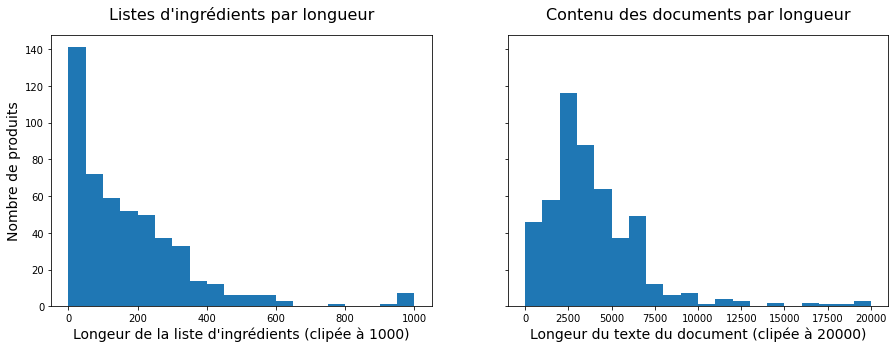

In [46]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 5), sharey=True)
axs[0].hist(lengths.loc['target'].clip(0, 1000), bins=20)
axs[0].set_title("Listes d'ingrédients par longueur", fontsize=16, pad=15)
axs[0].set_ylabel("Nombre de produits", fontsize=14)
axs[0].set_xlabel("Longeur de la liste d'ingrédients (clipée à 1000)", fontsize=14)
axs[1].hist(lengths.loc['content'].clip(0, 20000), bins=20)
axs[1].set_title("Contenu des documents par longueur", fontsize=16, pad=15)
axs[1].set_xlabel("Longeur du texte du document (clipée à 20000)", fontsize=14)
fig.savefig(Path('..') / 'img' / 'text_lengths.png', bbox_inches='tight')

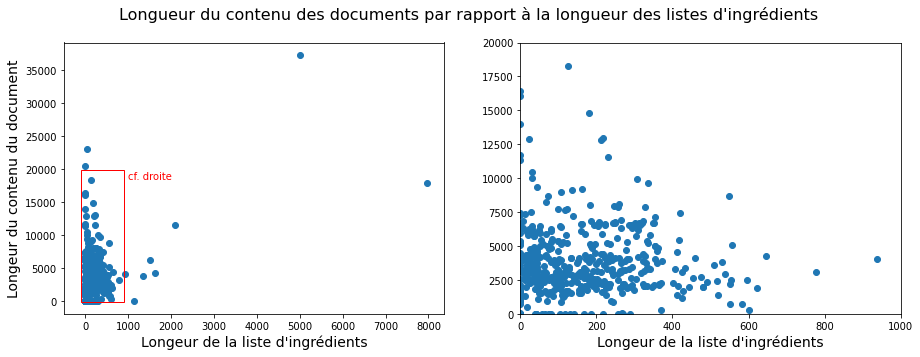

In [94]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 5))

axs[0].scatter(x=lengths.loc['target'], y=lengths.loc['content'])
axs[0].set_xlabel("Longeur de la liste d'ingrédients", fontsize=14)
axs[0].set_ylabel("Longeur du contenu du document", fontsize=14)
axs[0].add_patch(mpatch.Rectangle((-100, -150), 1000, 20000, fill=False, color='red'))
axs[0].annotate('cf. droite', (1000, 18500), color='red')
axs[1].scatter(x=lengths.loc['target'], y=lengths.loc['content'])
axs[1].set_xlabel("Longeur de la liste d'ingrédients", fontsize=14)
axs[1].set_xlim(0, 1000)
axs[1].set_ylim(0, 20000)
fig.suptitle("Longueur du contenu des documents par rapport à la longueur des listes d'ingrédients", fontsize=16)
fig.savefig(Path('..') / 'img' / 'text_lengths_2.png', bbox_inches='tight')

In [97]:
linregress(x=lengths.loc['target'], y=lengths.loc['content']).rvalue ** 2


0.139326761283587

In [171]:
stop_words = {'de', 'et', 'la', 'en', 'du', 'les', 'des', 'le', 'dans', 'ce', 'un', 'pour',
              'par', 'sur', 'au', 'dont', 'of', 'and', 'pas', 'est', 'ou'}

In [207]:
tfidf_corpus = TfidfVectorizer(strip_accents='unicode', 
                               lowercase=True,
                               stop_words=stop_words,
                               ngram_range=(1, 1),
                               max_df=1.0,
                               #min_df=0.0, A TESTER !
                               binary=False,
                               norm=None, # set to l1 or l2
                               use_idf=False,
                               smooth_idf=False,
                               sublinear_tf=False,
                              )
vectorized_corpus = tfidf_corpus.fit_transform(corpus_df['text'])
tokenizer = tfidf_corpus.build_analyzer()

Comptage des mots du vocabulaire du corpus : 

In [236]:
inverse_corpus_voc = {val: key for key, val in tfidf_corpus.vocabulary_.items()}
word_counts = np.asarray(vectorized_corpus.sum(axis=0)).squeeze()
print(f'Corpus vocabulary size is ', len(tfidf_corpus.vocabulary_), '\n')
print('Most frequent words in vocabulary are:')
for idx in word_counts.argsort()[::-1][:20]:
    print(f'{inverse_corpus_voc[idx].ljust(12)}: {word_counts[idx]:5} occurences')


Corpus vocabulary size is  15465 

Most frequent words in vocabulary are:
produit     : 2198.0 occurences
non         : 2164.0 occurences
produits    : 1508.0 occurences
10          : 1404.0 occurences
kg          : 1290.0 occurences
base        : 1119.0 occurences
sel         : 1041.0 occurences
poids       : 1021.0 occurences
100         : 971.0 occurences
palette     : 933.0 occurences
ingredients : 917.0 occurences
date        : 904.0 occurences
sucre       : 841.0 occurences
12          : 803.0 occurences
code        : 801.0 occurences
lait        : 733.0 occurences
absence     : 697.0 occurences
fiche       : 688.0 occurences
the         : 658.0 occurences
france      : 657.0 occurences


Constitution du vocabulaire des listes d'ingrédients

In [210]:
tfidf_ingred = clone(tfidf_corpus)
vectorized_ingred = tfidf_ingred.fit_transform(corpus_df.loc['target', 'text'])

In [255]:
inverse_ingred_voc = {val: key for key, val in tfidf_ingred.vocabulary_.items()}
word_counts = np.asarray(vectorized2.sum(axis=0)).squeeze()
print(f'Ingredient vocabulary size is ', len(model_ingred.vocabulary_), '\n')
print('Most frequent words in vocabulary are:')
for idx in word_counts.argsort()[::-1][:20]:
    print(f'{inverse_ingred_voc[idx].ljust(10)}: {word_counts[idx]:5} occurences')

Ingredient vocabulary size is  1324 

Most frequent words in vocabulary are:
sucre     : 363.0 occurences
acide     : 255.0 occurences
sel       : 240.0 occurences
sirop     : 180.0 occurences
eau       : 178.0 occurences
poudre    : 176.0 occurences
arome     : 175.0 occurences
lait      : 171.0 occurences
ble       : 171.0 occurences
huile     : 146.0 occurences
citrique  : 132.0 occurences
farine    : 128.0 occurences
amidon    : 125.0 occurences
glucose   : 124.0 occurences
cacao     : 122.0 occurences
extrait   : 117.0 occurences
acidifiant: 114.0 occurences
aromes    :  98.0 occurences
soja      :  96.0 occurences
concentre :  92.0 occurences


Constitution d'une nouvelle feature qui sont les textes tokenisés via la méthode du CountVectorizer.

In [212]:
corpus_df['tokenized'] = corpus_df['text'].apply(tokenizer)
corpus_df

text  \
source  uid                                                                                       
target  a0492df6-9c76-4303-8813-65ec5ccbfa70  Eau, maltodextrine, sel, arômes, sucre, arôme ...   
        d183e914-db2f-4e2f-863a-a3b2d054c0b8  Farine de blé T65, eau, levure, vinaigre de ci...   
        ab48a1ed-7a3d-4686-bb6d-ab4f367cada8  - 100% Semoule de BLE dur de qualité supérieur...   
...                                                                                         ...   
content e67341d8-350f-46f4-9154-4dbbb8035621  FICHE TECHNIQUE \n\nCREME BRÛLÉE 6L \n\nREF : ...   
        a8f6f672-20ac-4ff8-a8f2-3bc4306c8df3  81 rue de Sans Souci – CS13754 – 69576 Limones...   
        0faad739-ea8c-4f03-b62e-51ee592a0546   \n1050/10502066400 \n\n10502055300/1050202520...   

                                                                                      tokenized  
source  uid                                                                                      
target  a0492df6-9c76-4303-8813-65ec5ccbfa70  [eau, maltodextrine, sel, aromes, sucre, arome...  
        d183e914-db2f-4e2f-863a-a3b2d054c0b8  [farine, ble, t65, eau, levure, vinaigre, cidr...  
        ab48a1ed-7a3d-4686-bb6d-ab4f367cada8  [100, semoule, ble, dur, qualite, superieure, ...  
...                                                                                         ...  
content e67341d8-350f-46f4-9154-4dbbb8035621  [fiche, technique, creme, brulee, 6l, ref, nap...  
        a8f6f672-20ac-4ff8-a8f2-3bc4306c8df3  [81, rue, sans, souci, cs13754, 69576, limones...  
        0faad739-ea8c-4f03-b62e-51ee592a0546  [1050, 10502066400, 10502055300, 10502025200, ...  

[1000 rows x 2 columns]

# Analyse de données

## Représentations des textes

### tSVD

Je commence par faire un tSVD sur le corpus, en différenciant les ingrédients du texte des fiches techniques.

In [214]:
transformer = TruncatedSVD()
projected = transformer.fit_transform(vectorized_corpus)

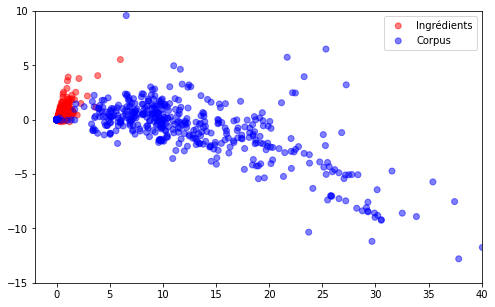

In [215]:
fig, ax = plt.subplots(figsize=(8, 5))
handles = []
handles.append(ax.scatter(x=projected[:500, 0], y=projected[:500, 1], c=['red']*500, alpha=0.5))
handles.append(ax.scatter(x=projected[500:, 0], y=projected[500:, 1], c=['blue']*500, alpha=0.5))
ax.set_ylim(-15, 10)
ax.set_xlim(-2, 40)
ax.legend(handles, ['Ingrédients', 'Corpus'])

Je fais une PCA sur les vecteurs de textes. Mais d'abord, il faut standardiser.

In [216]:
np.array(vectorized_corpus.todense())

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 2.,  1.,  0., ...,  0.,  0.,  0.],
       [11.,  0.,  0., ...,  0.,  0.,  0.]])

In [217]:
vectorized_std = StandardScaler().fit_transform(np.array(vectorized_corpus.todense()))

In [218]:
decomp = PCA(n_components=10).fit_transform(vectorized_std)

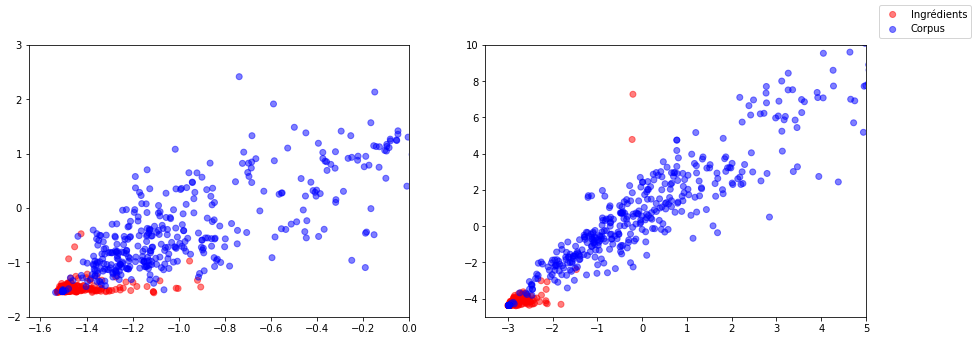

In [219]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 5))
handles = []
handles.append(ax[0].scatter(x=decomp[:500, 0], y=decomp[:500, 1], c=['red']*500, alpha=0.5))
handles.append(ax[0].scatter(x=decomp[500:, 0], y=decomp[500:, 1], c=['blue']*500, alpha=0.5))
ax[0].set_ylim(-2, 3)
ax[0].set_xlim(-1.65, 0)
ax[1].scatter(x=decomp[:500, 2], y=decomp[:500, 3], c=['red']*500, alpha=0.5)
ax[1].scatter(x=decomp[500:, 2], y=decomp[500:, 3], c=['blue']*500, alpha=0.5)
ax[1].set_ylim(-5, 10)
ax[1].set_xlim(-3.5, 5)
fig.legend(handles, ['Ingrédients', 'Corpus'])

## TODO : refaire pour un comptage fréquentiel plutôt qu'en valeur absolue

# Représentation des mots

## Document frequency

1- Déjà, on calcule une métrique qui permet de dire si un mot est plutôt un mot de type ingrédients ou un mot issu du corpus.

Représentation simple : on regarde simplement la document frequency de chacun des mots dans le corpus des ingrédients.


In [229]:
doc_freq_counter = clone(tfidf_ingred)
doc_freq_counter.set_params(binary=True).fit(corpus_df.loc['target', 'text'])
binary_ingred_counts = doc_freq_counter.transform(corpus_df.loc[:, 'text'])

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]])

In [383]:
doc_freq_ingred = binary_ingred_counts[:500]
doc_freq_ingred = np.array(doc_freq_ingred.sum(axis=0)).reshape(-1) / 500
print('shape of doc_freq_ingred :', doc_freq_ingred.shape)
doc_freq_ingred_translator = defaultdict(lambda: 0., {word: doc_freq_ingred[tfidf_ingred.vocabulary_[word]]
                              for word in tfidf_ingred.vocabulary_.keys()})

print(doc_freq_ingred_translator['sucre'])
print(doc_freq_ingred_translator['taboulllleeeeeeeiiiiiii'])
print(doc_freq_ingred_translator['maltodextrine'])

shape of doc_freq_ingred : (1324,)
0.448
0.0
0.064


On constitue un array qui nous servira plus tard, avec le document frequency dans les ingrédients de chacun des mots.

In [384]:
corpus_doc_freq_ingred = np.zeros(shape=(len(tfidf_corpus.vocabulary_)))
for i in range(len(tfidf_corpus.vocabulary_)):
    corpus_doc_freq_ingred[i] = doc_freq_ingred_translator[inverse_corpus_voc[i]]
corpus_doc_freq_ingred

array([0.004, 0.   , 0.   , ..., 0.   , 0.   , 0.   ])

In [385]:
corpus_doc_freq_ingred.argsort()[-3:]

array([ 7217, 13515, 14079])

(array([1.5376e+04, 5.4000e+01, 1.6000e+01, 8.0000e+00, 5.0000e+00,
        3.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([0.    , 0.0448, 0.0896, 0.1344, 0.1792, 0.224 , 0.2688, 0.3136,
        0.3584, 0.4032, 0.448 ]),
 <a list of 10 Patch objects>)

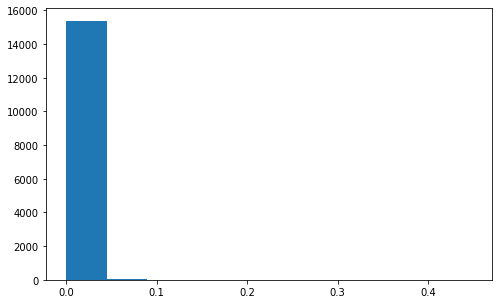

In [386]:
fig,ax = plt.subplots(figsize=(8, 5))
ax.hist(corpus_doc_freq_ingred)

(array([1.5361e+04, 5.8000e+01, 2.2000e+01, 8.0000e+00, 9.0000e+00,
        3.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([0.        , 0.01607686, 0.03215371, 0.04823057, 0.06430742,
        0.08038428, 0.09646114, 0.11253799, 0.12861485, 0.14469171,
        0.16076856]),
 <a list of 10 Patch objects>)

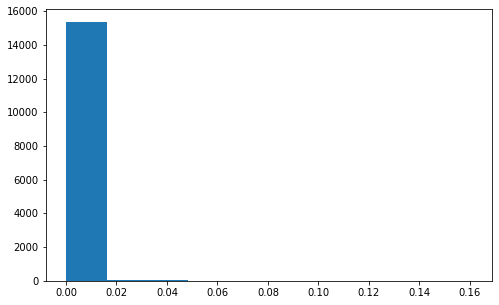

In [388]:
fig,ax = plt.subplots(figsize=(8, 5))
ax.hist(np.log10(corpus_doc_freq_ingred + 1))

## Word embedings

### Word2Vec

On calcule les embeddings avec Word2Vec

In [389]:
word2vec_model = word2vec.Word2Vec(corpus_df['tokenized'], min_count=1)

In [390]:
for i, word in enumerate(tfidf_corpus.vocabulary_.keys()):
    print('--------------------\n', word, ':', word2vec_model.wv[word][:5])
    if i > 4:
        break

--------------------
 eau : [ 1.5438923   1.2105024  -0.90852946  1.1155081  -0.43450546]
--------------------
 maltodextrine : [ 2.9105140e-04  2.9659006e-01 -7.8798190e-02  7.0432030e-02
 -3.2774822e-03]
--------------------
 sel : [-0.0441541   0.78801465  0.18098342  0.2767495  -0.46430096]
--------------------
 aromes : [-0.13763303  0.9511325  -0.10449786  0.31044248  0.02515987]
--------------------
 sucre : [ 1.1325544   1.3320696  -0.40036973  0.3355728   0.21263881]
--------------------
 arome : [-0.3191383   1.4332119  -0.04708712  0.15841252  0.11661642]


In [391]:
ndarray_words_embeddings = np.vstack([word2vec_model.wv[inverse_corpus_voc[i]]
                                      for i in range(len(tfidf_corpus.vocabulary_))])
ndarray_words_embeddings

array([[ 6.8101692e-01, -2.7750158e-01, -4.2664763e-01, ...,
         7.7155036e-01, -4.8310643e-01,  1.6730446e+00],
       [ 1.4449192e+00, -3.6964747e-01, -1.7234201e+00, ...,
         1.0338728e+00,  1.1325694e+00,  5.8280629e-01],
       [ 3.5117552e-02,  8.1412628e-02, -1.0179559e-01, ...,
         6.3129440e-02,  2.6871787e-02,  1.2238390e-01],
       ...,
       [ 2.9680310e-03,  8.2927523e-03, -6.5626539e-03, ...,
         2.4423879e-02, -1.0176204e-03,  2.2665268e-02],
       [ 4.5920265e-01,  1.7069811e-01, -5.2242464e-01, ...,
         4.0738910e-01,  2.4141511e-01,  5.2641755e-01],
       [ 4.8106816e-02, -6.3263811e-04, -2.6684624e-01, ...,
         2.2788006e-01,  1.7259644e-02,  9.5975228e-02]], dtype=float32)

On effectue une PCA : 

In [392]:
scaled_words_embeddings = StandardScaler().fit_transform(ndarray_words_embeddings)
scaled_words_embeddings

array([[ 5.3174658e+00, -3.0815985e+00, -1.7325752e+00, ...,
         7.4722404e+00, -4.8668489e+00,  1.2989073e+01],
       [ 1.1483762e+01, -4.0512576e+00, -8.3605785e+00, ...,
         1.0093655e+01,  1.1379594e+01,  4.5758662e+00],
       [ 1.0370139e-01,  6.9528723e-01, -7.2206393e-02, ...,
         3.9292228e-01,  2.6124179e-01,  1.0228550e+00],
       ...,
       [-1.5581276e-01, -7.4159622e-02,  4.1454378e-01, ...,
         6.1338940e-03, -1.9200396e-02,  2.5334123e-01],
       [ 3.5269589e+00,  1.6348461e+00, -2.2221062e+00, ...,
         3.8331423e+00,  2.4185841e+00,  4.1407228e+00],
       [ 2.0855203e-01, -1.6808228e-01, -9.1580564e-01, ...,
         2.0392911e+00,  1.6458680e-01,  8.1906331e-01]], dtype=float32)

In [478]:
PCA_model = PCA(n_components=10).fit(scaled_words_embeddings)
PCA_words_embeddings = PCA_model.fit_transform(scaled_words_embeddings)
print(PCA_words_embeddings.shape)

(15465, 10)


(0.0, 100.0)

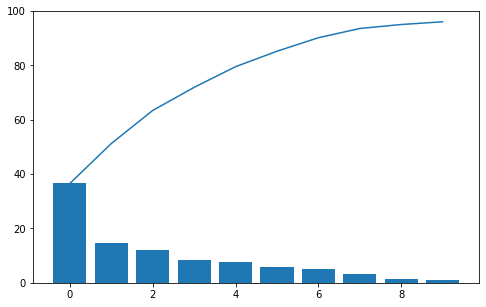

In [486]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(PCA_model.explained_variance_.cumsum())
ax.bar(x=range(10), height=PCA_model.explained_variance_)
ax.set_ylim(0, 100)

On la dessine : 

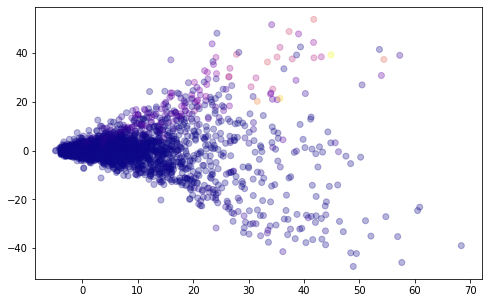

In [489]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(x=PCA_words_embeddings[:, 0],
           y=PCA_words_embeddings[:, 1],
           alpha=0.3,
           cmap=plt.get_cmap('plasma'),
           c=np.log2(corpus_doc_freq_ingred + 1),
          )


On n'y voit goutte, on va sampler l'array :

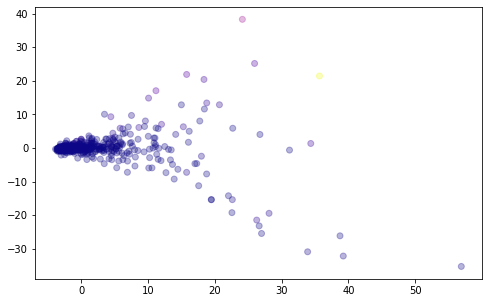

In [491]:
rand_idx = np.random.choice(np.arange(len(corpus_doc_freq_ingred)), 1000)

fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(x=PCA_words_embeddings[rand_idx, 0],
           y=PCA_words_embeddings[rand_idx, 1],
           alpha=0.3,
           cmap=plt.get_cmap('plasma'),
           c=np.log10(corpus_doc_freq_ingred + 1)[rand_idx],
          )


Ce n'est pas beaucoup mieux. On va retirer les mots qui ne sont pas des ingrédients.

In [475]:
corpus_doc_freq_ingred[corpus_doc_freq_ingred > 0.]

1324

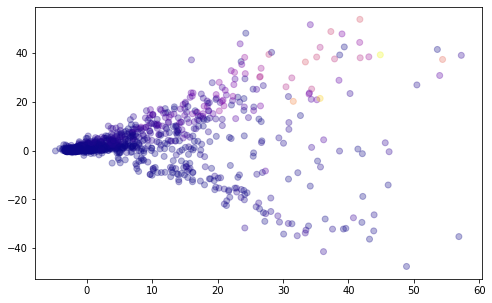

In [476]:
idx = corpus_doc_freq_ingred > 0.

fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(x=PCA_words_embeddings[idx, 0],
           y=PCA_words_embeddings[idx, 1],
           alpha=0.3,
           cmap=plt.get_cmap('plasma'),
           c=np.log10(corpus_doc_freq_ingred + 1)[idx],
          )


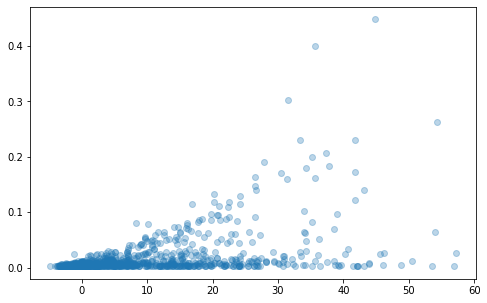

In [488]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(x=PCA_words_embeddings[idx, 0],
           y=(corpus_doc_freq_ingred)[idx],
           alpha=0.3,
           #cmap=plt.get_cmap('plasma'),
           #c=np.log10(corpus_doc_freq_ingred + 1)[idx],
          )


In [497]:
linregress(x=PCA_words_embeddings[idx, 0], y=(corpus_doc_freq_ingred)[idx]).rvalue ** 2


0.23912652040393936